# COMPAS analysis
----

This document was reproduced in order to understand the controvery that [PP analysis](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb) raised. In May 2016, Angwin, et al. published an article in [ProPublica article (PP)](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) where they claimed that COMPAS, a widely used risk assessment tool, aka recidivism model, is baised against blacks [1]. According to their analysis, black defendants who do not recidivate were nearly twice as likely to be misclassified by COMPAS as higher risk compared to their white counterparts (45 % vs. 23 %), and  white defendants who scored who re-offended within the next two years were mistakenly labeled low-risk almost twice as often as black reoffenders (48 % vs. 28 %).

Two months later, Northpointe-- the company that sells COMPAS -- refuted Angwin, et al. study in the paper, "COMPAS Risk Scales: Demonstrating Accuracy Equity and Predictive Parity" [2]. Brennan et al. write that PP's study didn't classify the defendents properly and suggested the high category be 8-10 and not high category be 1-7. They criticized ProPublica for not using Area Under the Curve, which captures the base rate (the reality of those who did recidivate) for each group. They found that in comparison with whites a slightly lower percentage of blacks were "Labeled Higher Risk, But Didn't Re-Offend" (37% vs. 41%) and only a slightly higher percentage of blacks were "Labeled Lower Risk, Yet Did Re-Offend" (35% vs. 29%). 


## Brief summary on Correctional Offender Management Profiling for Alternative Sanctions (COMPAS)

COMPAS was first developed in 1998 and has been used to assess more than 1 million offenders
since it was developed (12). COMPAS was designed to optimize the overloaded and crowded
criminal justice system so that case management considerations are easy, and time management
is efficient and effective. 

The COMPAS instrument uses some combination of 137 questions to assess three types of risk scales: general recidivism, violent recidivism, and pretrial misconduct. According to Northpointe the scale inputs for general recidivism risk score (GRRS) include criminal involvement (prior arrests and prior sentences to jail, prison, and probation), vocational/educational problems, drug history, age-at-assessment, and age-at-first-arrest. The scale inputs for violent recidivism risk score (VRRS) include the history of violence, history of noncompliance, vocational/ educational problems, the person's age-at-assessment and the person's age-at-first-arrest. It is unclear what combination of other inputs and their weights are used in each of the three types of risk assessment. Using the inputs, COMPAS generates a raw score which is then converted into decile scores from 1 to 10. The scores are then assigned to risk categories: low-risk if 1 to 4; medium risk if 5 to 7; high-risk 8 to 10.

Angwin et al. received data for 18,610 people who were assessed using COMPAS in the year 2013 and 2014. However, for the initial analysis, they filtered the people who were assessed at parole, probation or other stages in the criminal justice system because Broward County primarily uses the score to determine whether to release or detain a defendant before trial. Brennan, et al. pointed out that failure to appear (FTA) risk score is primarily focused on pretrial defendants which were not incorporated in PP's study. Northpointe’s practitioners guide, which says that its recidivism score is meant to predict “a new misdemeanor or felony offense within two years of the COMPAS administration date.”

Angwin et al. collected public criminalrecords from the Broward County Clerk’s Office website for 11757 people and created two types of datasets `compas_scores_two_years` with 7214 people for General Recidivism, and `compas_scores_two_years_violent` with  4743 people for Violent Recidivism. I will use those datasets published on the github and recreate Angwin et al. analysis and the studies that followed up with several fairness criteria. 


# Table `compas_scores_two_years` & `compas_scores_two_years_violent`

Angwin et al. used `compas_scores_two_years` table for their initial analysis and plotted histograms of the general recidivism risk score (GRRS) for black and white defendants and `compas_scores_two_years_violent` table and plotted histograms of the violent recidivism risk score (VRRS) for black and white defendants.

In `compas_scores_two_years_violent`, are `is_recid` and `two_year_recid` supposed to be `is_violent_recid` and `two_year_recid_1` ?? 
Presumably, `is_violent_recid` is coded with 1 if the person ever recidivated with violence and 0 if not. The number of rows for the dataset, when filtered by `is_violent_recid` and `two_year_recid_1`, is 4020 too. 

I analyzed only GRRS because of the uncertainty in a variable associated with violent recidivist within two years. For instance, ProPublica mistakenly filtered `is_recid` instead of `is_violent_recid` for violent recidivism risk score. 


# Predicted Score and Acutual Outcome
- Decile Scores 

The datasets consist of a column with decile scores (1-10) as probability prediction of reoffense. 

- Is Recidivist 

There are two columns: is_recid and two_year_recid. The values are coded as 1 if the person re-offended, 0 if did not reoffend, and -1 if the COMPAS information was not found. 

I thought about doing my analysis with 18610 people in `compas_scores_raw` table, but I do not have the data on `prisonhistory`, `jailhistory`, etc on those people who are not pretrial defendents (See table `compas_scores`). These tables will be relevent when testing for Disparate Treatement. 

They list the following reasons for why they used only 6172 out of 11,000 data points:

- They filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

- They coded `is_recid` for those who have recidivated as 1, did not recidivate as 0 and no compas case as -1. 

They selected fields for severity of charge, number of priors, demographics, age, sex, COMPAS scores, and whether each person was accused of a crime within two years. 

- The variable called `two_year_recid` are those who recidivated within two years or had at least two years outside of correctional facility as 0 or 1. 

- Those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).

- If the charge date of a defendants COMPAS scored crime was not within 30 days from when the person was arrested, they assume that because of data quality reasons, that they do not have the right offense.

During their initial analysis, Angwin et al. filtered their data by keeping only the cases where the days between arrest and compas screening date was 30, which reduced the size of data from 7214 to 6172. However, they used the data without filteration to calculate statistics such as False Positive Rate and False Negative Rate mentioned in the first paragraph of this document. Therefore I will proceed my analyses with filtering the data. 


In [1]:
# Load necessary R packages
suppressWarnings(
    suppressMessages(
        easypackages::packages("plyr",
                               "dplyr",
                               "readr", 
                               "ggplot2",
                               "scales",
                               "data.table", 
                               "tidyr", 
                               "dataPreparation",
                               "corrplot",
                               "ROCR",
                               "pROC",
                               "randomForest",
                               "caret",
                               "e1071",
                               "randomForestExplainer",
                               "rmarkdown",
                               "gridExtra",
                               "reprtree")))

# install.packages("github.com/d-ghale/DataScienceR/easyDataScience")
# update.packages(ask = FALSE)


In [27]:
# Function to loads a file and replaces blank space by NA using na.string
load_datatable <- function( file ) {
    fread(file = file,
          na.strings = c("", "NA"), 
          check.names = TRUE # ensure that columns with the same name are given different names
          )
}

# Function that removes any duplicate rows 
remove_duplicate_rows <- function( data ) {
    data.table(distinct( data ))
}

# summary() function is only useful for numeric and logical type variables
# cannot compute mean, median, etc, on character and logical types 
# also the functions' output is not in tidy format 
# transform each variable as a row and each type of statistics as a column with its corresponding value 

#' count the number of unique values in each variable
summary_dcount <- function(data) {
    dcount_func <- function(x){
        data.frame(count_distinct = n_distinct(x))
    }
    summary_data <- adply(data, 2, dcount_func )
    names(summary_data)[1] <- "Variable"
    data.frame(lapply(summary_data, trimws), stringsAsFactors = FALSE)
}


#' first of all find all of the columns that are dates
#' r doesn't have a simple function for that so we will build our own function
is_date <- function(x) {
	require(lubridate)
	if (class(x) == "data.frame")	warning("x is not a array")
	!all(is.na(as.Date(as.character(x), format = c("%Y-%m-%d", "%Y/%m/%d","%d-%m-%Y","%m-%d-%Y"))))
}

summary_dates <- function(data){
	date_data <- data[, lapply(data, is_date) == TRUE, with = FALSE]
	if (nrow(date_data) > 0){
		cols <- colnames(date_data)
		#' covert all of the dates into one format for consistency
		setColAsDate(date_data, cols = cols, format = c("%Y-%m-%d %H:%M:%S", "%Y-%m-%d"))
		summary_table <- summary(date_data)
		#' We can't use ":" to separate like in summary_numbers() because of %H:%M:%S in the column
		#' Therefore we are using the regular expression to split using the first occurance of ":" and keeping the remaining values
		data.frame(summary_table) %>%
			separate(Freq, c("type", "value"), "\\:(?=\\d)", extra = "merge") %>%
			select(- Var1)
	} else {
		date_data
	}
}

#' compute basic statistics for number types
summary_numbers <- function(data) {
	numeric_data <- data[, lapply(data, is.numeric) == TRUE, with = FALSE]
	summary_table <- data.frame(summary(numeric_data))
	summary_table <- summary_table  %>%
		separate(Freq, c("type", "value"), ":") %>%
		select(- Var1)
	summary_table$value <- round(as.numeric(summary_table$value), 2)
	summary_table
}

#' both numbers and numbers
join_summary <- function(data){
	summary_data <- rbind(summary_dates(data), summary_numbers(data)) %>%
		spread(type, value)
	summary_data <- summary_data %>% replace(., is.na(.), "-")
	names(summary_data)[1] <- "Variable"
	#' string with . at end gives odd results when removing whitespace
	summary_data <- data.frame(lapply(summary_data, trimws), stringsAsFactors = FALSE)
	names(summary_data) <- gsub("[.]", "", names(summary_data))
	#' Order some of the columns
	setnames(summary_data, old = c("X1stQu", "X3rdQu"), new = c( "First.Qu", "Third.Qu"))
	col_order <- c("Variable", "Min", "First.Qu",  "Mean", "Median", "Third.Qu", "Max")
	setcolorder(summary_data, c(col_order, setdiff(names(summary_data), col_order)))
	summary_data
}

#' count the number of TRUE and FALSE for logical type
summary_logicals <- function(data){
	logical_data <- data[, lapply(data, is.logical) == TRUE, with = FALSE]
	if (nrow(logical_data) > 0){
		summary_data <- data.frame(summary(logical_data)) %>%
			select(-Var1) %>%
			separate(Freq, c("type", "value"), ":")
		summary_data$type <- trimws(summary_data$type)
		summary_data <- summary_data %>%
			spread(type, value) %>%
			select(- Mode)
		names(summary_data)[1] <- "Variable"
		data.frame(lapply(summary_data, trimws), stringsAsFactors = FALSE)
	} else {
		logical_data
	}
}

handle_name <- function(data){
	#' find colnames with "NA" in it
	col_names <- colnames(data)[grepl("NA", colnames(data)) == TRUE]
	colnames(data)[which(colnames(data) %in%  col_names)] <- "None"
	None_data <- data.frame(data, check.names = TRUE) #' don't allow duplicate names
	col_names2 <- colnames(None_data)[grepl("None", colnames(None_data)) == TRUE]
	cols_join <- None_data[, names(None_data) %in% col_names2]
	if(length(col_names) > 1){
		None <- as.vector(do.call(coalesce, cols_join))
		cbind(None_data[, - which(names(None_data) %in% col_names2)], None)
	} else {
		None_data
	}
}

tidy_summary <- function(data){
	dcount_data <- data.frame(summary_dcount(copy(data)))
	numbers_data <- data.frame(handle_name(join_summary(copy(data))))
	logicals_data <- data.frame(handle_name(summary_logicals(copy(data))))
	if (nrow(logicals_data) == 0 & nrow(numbers_data) == 0) {
		full_summary <- dcount_data
	} else if (nrow(logicals_data) == 0) {
		full_summary <- merge(dcount_data, numbers_data, by = "Variable", all = TRUE)
	} else {
		full_summary <- merge(dcount_data, merge(logicals_data, numbers_data, by = c("Variable", "None"), all = TRUE) , by = "Variable", all = TRUE)
	}
	full_summary  %>% replace(., is.na(.), "-")
}

# Function that counts distinct values based on group/s 
count_unique_keys <- function(data, ...) {
    distinct_(data[,...]) %>%
        nrow()
}

# Function that prints distinct values based on one group
unique_keys_one <- function(data, ...) {
    distinct_(data[,...]) %>% 
        pull(...) # print as a vector instead of a column format
}

# Function that prints distinct values based on more than one group
unique_keys_more <- function(data, ...) {
    distinct_(data[,...]) # print as column format
}


In [205]:
compas_two_years_data <- load_datatable('/Users/domaghale/Documents/COMPAS/compas-analysis-master/compas-scores-two-years.csv')
head(compas_two_years_data)
dim(compas_two_years_data)

compas_two_years_data_no_dup <- remove_duplicate_rows(copy(compas_two_years_data)) 
dim(compas_two_years_data_no_dup)
colnames(compas_two_years_data_no_dup)
# No duplicate rows

summary(compas_two_years_data_no_dup)

id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,⋯,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,⋯,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,⋯,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,⋯,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,⋯,6,Medium,2013-01-13,NA,NA,1,0,1174,0,0
6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,⋯,1,Low,2013-03-26,NA,NA,2,0,1102,0,0
7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,⋯,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0


[1] 7214   53

[1] 7214   53

[1] "id"                      "name"                   
 [3] "first"                   "last"                   
 [5] "compas_screening_date"   "sex"                    
 [7] "dob"                     "age"                    
 [9] "age_cat"                 "race"                   
[11] "juv_fel_count"           "decile_score"           
[13] "juv_misd_count"          "juv_other_count"        
[15] "priors_count"            "days_b_screening_arrest"
[17] "c_jail_in"               "c_jail_out"             
[19] "c_case_number"           "c_offense_date"         
[21] "c_arrest_date"           "c_days_from_compas"     
[23] "c_charge_degree"         "c_charge_desc"          
[25] "is_recid"                "r_case_number"          
[27] "r_charge_degree"         "r_days_from_arrest"     
[29] "r_offense_date"          "r_charge_desc"          
[31] "r_jail_in"               "r_jail_out"             
[33] "violent_recid"           "is_violent_recid"       
[35] "vr_case_number"          "vr_charge_degree"       
[37] "vr_offense_date"         "vr_charge_desc"         
[39] "type_of_assessment"      "decile_score.1"         
[41] "score_text"              "screening_date"         
[43] "v_type_of_assessment"    "v_decile_score"         
[45] "v_score_text"            "v_screening_date"       
[47] "in_custody"              "out_custody"            
[49] "priors_count.1"          "start"                  
[51] "end"                     "event"                  
[53] "two_year_recid"

       id            name              first               last          
 Min.   :    1   Length:7214        Length:7214        Length:7214       
 1st Qu.: 2735   Class :character   Class :character   Class :character  
 Median : 5510   Mode  :character   Mode  :character   Mode  :character  
 Mean   : 5501                                                           
 3rd Qu.: 8246                                                           
 Max.   :11001                                                           
                                                                         
 compas_screening_date     sex                dob                 age       
 Length:7214           Length:7214        Length:7214        Min.   :18.00  
 Class :character      Class :character   Class :character   1st Qu.:25.00  
 Mode  :character      Mode  :character   Mode  :character   Median :31.00  
                                                             Mean   :34.82  
                       

When trying to find the basic statistics we get: 
        
    "Error in summarise_impl(.data, dots): Columns `decile_score`, `priors_count` must have a unique name"

Using `whichAreInDouble()` function from dataPreparation package we identified variables that are duplicates. 
    
    compas_screening_date == screening_date == v_screening_date 
    decile_score.1 == decile_score
    priors_count.1 == priors_count. 

Let's drop duplicate columns. 

Use `fastFilterVariables()` function from dataPreparation package to drop the double values. Unfortuanately, the function allows us to drop double values only with constant values or bijection values. Read the [document](https://cran.r-project.org/web/packages/dataPreparation/dataPreparation.pdf) for detail. We will check which values are constant to make sure we are not eliminating important variables. Then use the function to filter the double and constant values. 

Using `whichAreConstant()` function from the package we identified the following variables in that have only one value.
- violent_recid
- type_of_assessment
- v_type_of_assessment

Constant values are not possible to be used as predictors in our model. In case of a single value and NA, the model will drop NA by default again giving the same error. Hence we must treat NA's with other values. Few common ways are to replace it with "missing" for character type and 999 for numeric type. In our case we will remove all of them since they do not add any information to our model.  


In [203]:
test_data <- copy(compas_two_years_data)
# There are duplicate columns
dataPreparation::whichAreInDouble(test_data)

# There are columns with only one values 
dataPreparation::whichAreConstant(test_data)

unique_keys_more(test_data, c("violent_recid", "type_of_assessment", "v_type_of_assessment"))

[1] "whichAreInDouble: compas_screening_date is exactly equal to screening_date. I put it in drop list."
[1] "whichAreInDouble: decile_score.1 is exactly equal to decile_score. I put it in drop list."
[1] "whichAreInDouble: priors_count.1 is exactly equal to priors_count. I put it in drop list."
[1] "whichAreInDouble: screening_date is exactly equal to v_screening_date. I put it in drop list."
[1] "whichAreInDouble: it took me 0.12s to identify 4 column(s) to drop."


[1]  5 40 42 49

[1] "whichAreConstant: violent_recid is constant."
[1] "whichAreConstant: type_of_assessment is constant."
[1] "whichAreConstant: v_type_of_assessment is constant."
[1] "whichAreConstant: it took me 0.05s to identify 3 constant column(s)"


[1] 33 39 43

violent_recid,type_of_assessment,v_type_of_assessment
NA,Risk of Recidivism,Risk of Violence


In [204]:
# remove constants and doubles 
# Keep only `type_of_assessment` column among constant ones 
filtered_compas_data <- dataPreparation::fastFilterVariables(
                            copy(compas_two_years_data), level = 2, 
                            keep_cols = c("compas_screening_date", "decile_score", "priors_count"))
dim(filtered_compas_data)

tidy_summary(filtered_compas_data)

# don't know why keep_cols is not keeping `compas_screening_date` or `screening_date` when listed 
# We saw that three columns `compas_screening_date`, `compas_screening_date` and `v_screening_date` have exact same values. 
# so we will rename `v_screening_date` as `compas_screening_date` for the consistency 

clean_compas_data <- copy(filtered_compas_data)
colnames(clean_compas_data)[colnames(clean_compas_data) == "v_screening_date"] <- "compas_screening_date"

unique_keys_one(clean_compas_data, "score_text")
# No "N/A" 
unique_keys_one(clean_compas_data, "is_recid")
# No "-1"
unique_keys_one(clean_compas_data, "c_charge_degree")
# No "O"

[1] "fastFilterVariables: I check for constant columns."
[1] "fastFilterVariables: I delete 3 constant column(s) in dataSet."
[1] "fastFilterVariables: I check for columns in double."
[1] "fastFilterVariables: I delete 4 column(s) that are in double in dataSet."


[1] 7214   46

[1] "setColAsDate: I will set some columns as Date."
[1] "setColAsDate: I am doing the column dob."
[1] "setColAsDate: I am doing the column c_jail_in."
[1] "setColAsDate: I am doing the column c_jail_out."
[1] "setColAsDate: I am doing the column c_offense_date."
[1] "setColAsDate: I am doing the column c_arrest_date."
[1] "setColAsDate: I am doing the column r_offense_date."
[1] "setColAsDate: I am doing the column r_jail_in."
[1] "setColAsDate: I am doing the column r_jail_out."
[1] "setColAsDate: I am doing the column vr_offense_date."
[1] "setColAsDate: I am doing the column v_screening_date."
[1] "setColAsDate: I am doing the column in_custody."
[1] "setColAsDate: I am doing the column out_custody."
[1] "setColAsDate: it took me: 0.28s to transform 12 column(s) to Dates."


Variable,count_distinct,Min,First.Qu,Mean,Median,Third.Qu,Max,None
age,65,18,25,34.82,31,42,96,-
age_cat,3,-,-,-,-,-,-,-
c_arrest_date,581,1997-06-18 00:00:00,2013-02-13 00:00:00,2013-04-25 09:40:03,2013-06-17 00:00:00,2013-12-05 00:00:00,2014-12-27 00:00:00,6077
c_case_number,7193,-,-,-,-,-,-,-
c_charge_degree,2,-,-,-,-,-,-,-
c_charge_desc,438,-,-,-,-,-,-,-
c_days_from_compas,500,0,1,57.73,1,2,9485,22
c_jail_in,6908,2013-01-01 01:31:55,2013-04-07 03:30:24,2013-09-26 12:25:12,2013-09-13 03:59:13,2014-01-28 12:31:36,2016-03-11 10:26:16,307
c_jail_out,6881,2013-01-02 01:12:01,2013-04-23 18:02:38,2013-10-15 05:47:08,2013-10-01 07:40:06,2014-02-10 08:22:38,2016-03-12 01:11:40,307
c_offense_date,928,1987-11-07 00:00:00,2013-03-22 00:00:00,2013-08-10 15:47:28,2013-08-26 00:00:00,2014-01-17 00:00:00,2014-12-30 00:00:00,1159


[1] "Low"    "High"   "Medium"

[1] 0 1

[1] "F" "M"

In [206]:
final_compas_data <- clean_compas_data[,.(compas_screening_date, c_charge_degree, r_charge_degree,
                                      vr_charge_degree, sex, age, age_cat, race, decile_score,
                                      score_text, is_recid, two_year_recid )]
dim(final_compas_data)

[1] 7214   12

In [207]:
# keep only the variables to count
vars_data <- function(data){
    copy(data)[,.(race, sex, age_cat, score_text, is_recid, two_year_recid, 
                  c_charge_degree, r_charge_degree, vr_charge_degree, decile_score)]
}

vars_data1 <- vars_data(copy(final_compas_data))

count_per_var <- function(data, ...){
    count(data, ...)   
}

lst_counts <- function(data){
    # create seperate list with each variable
    lst <- list()
    for (i in 1:ncol(data)){
        lst[[i]] <- count_per_var(data, data[[i]])
        names(lst[[i]]) <- c(eval(colnames(data[, ..i])), "count")
    }  
    lst
}

count_vars1 <- lst_counts(vars_data1)
count_vars1

race,count
African-American,3696
Asian,32
Caucasian,2454
Hispanic,637
Native American,18
Other,377
sex,count
Female,1395
Male,5819
age_cat,count


In [173]:
#' count the number of rows grouped by unique values in each variable
count_score_per_var <- function(data, ...) {
    count(data, decile_score, ...)
}
     
count_score_lst <- function(data){
   # create seperate list with each variable
    lst <- list()
    # for each decile_score value count the number of rows in each group of each variable 
    # decile_score variable is placed as the last variable for this reason 
    no_score <- ncol(data) - 1
    for (i in 1:no_score){
    lst[[i]] <- as.data.frame(count_score_per_var(data, data[[i]])) %>%
                    spread("data[[i]]", "n")
   
} 
 lst 
} 

count_score_vars1 <- count_score_lst(vars_data1)
count_score_vars1

decile_score,African-American,Asian,Caucasian,Hispanic,Native American,Other
1,365,15,605,159,NA,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,NA,243,47,NA,39
5,323,1,200,39,NA,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,NA,7
9,317,NA,77,17,2,7
10,227,1,50,16,2,8


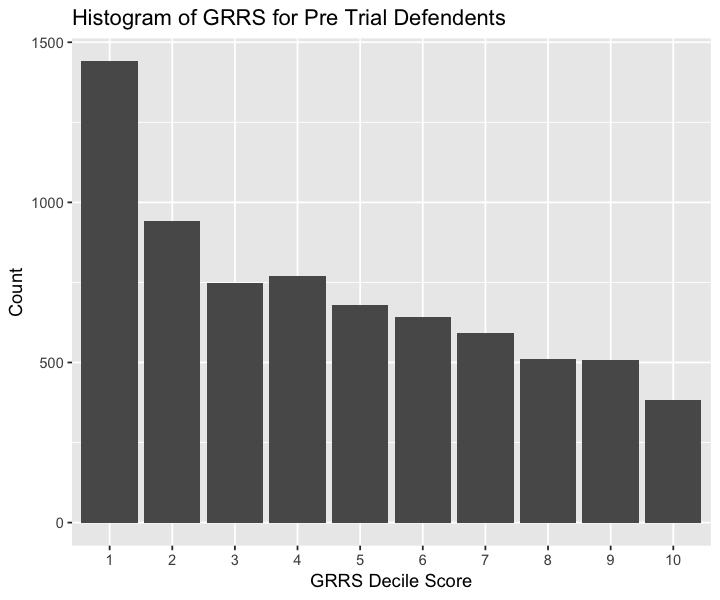

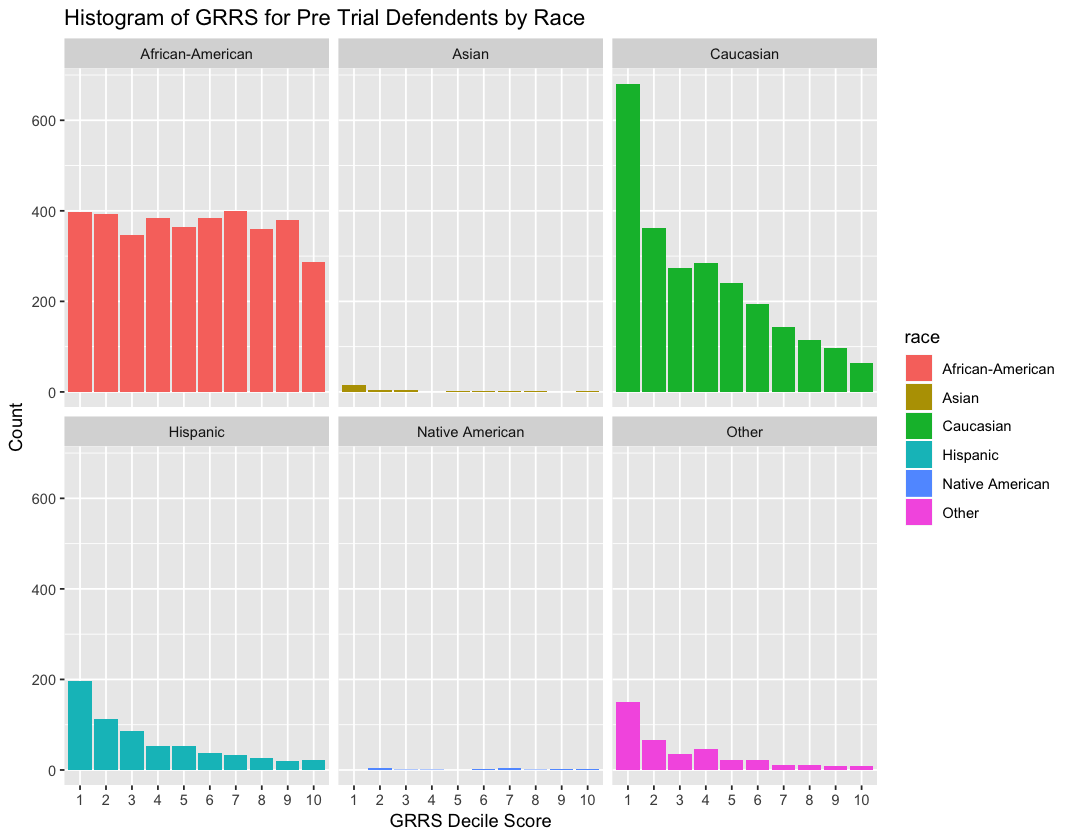

In [242]:
df <- copy(final_compas_data)

df$decile_score <- factor(df$decile_score, c("1", "2","3","4","5","6", "7", "8", "9", "10"))

options(repr.plot.width = 6, repr.plot.height = 5)
df %>%
    ggplot(aes(ordered(decile_score))) + 
    geom_bar() + 
    xlab("GRRS Decile Score")  + 
    ylab("Count") +
    ggtitle("Histogram of GRRS for Pre Trial Defendents") 

options(repr.plot.width = 9, repr.plot.height = 7)

df %>% 
    ggplot(aes(decile_score, fill= race)) + 
    geom_bar(stat = "count") +
    xlab("GRRS Decile Score") + 
    ylab("Count") +
    ggtitle("Histogram of GRRS for Pre Trial Defendents by Race") +
    facet_wrap(~race) 
  

The graph above shows that the proportion of number of people in each decile score is not exactly 10 %. This raises the question whether the complete dataset that was used to obtain the decile scores are equal in proportion. 

I will filter the dataset for African-American and Caucasian to match with Angwin et al. study. The histogram shows that the distribution of people in each decile score vary immensely between black and white defendents. 

The difference in median is shown better with a boxplot. The boxplot represents percentiles (25th, 50th, 75th) such that the outliers are shown as dots. The first quartile (25th percentile) is shown as the lower border, the third quartile (75th percentile) is the upper border, and the median (50th percentile) is the line that lies in between those borders. The median score for African-American is 5, whereas for Caucasian is 3. 

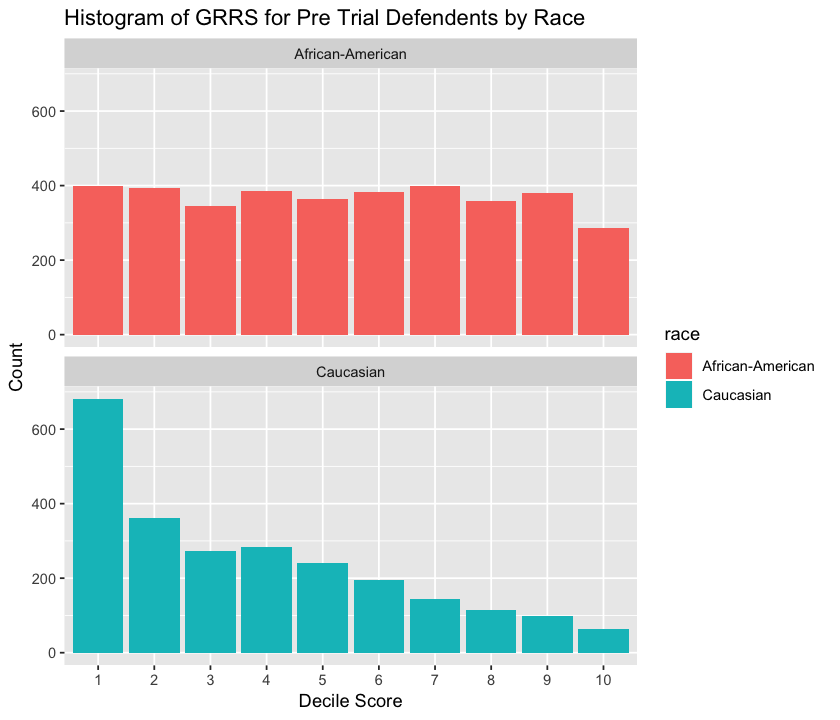

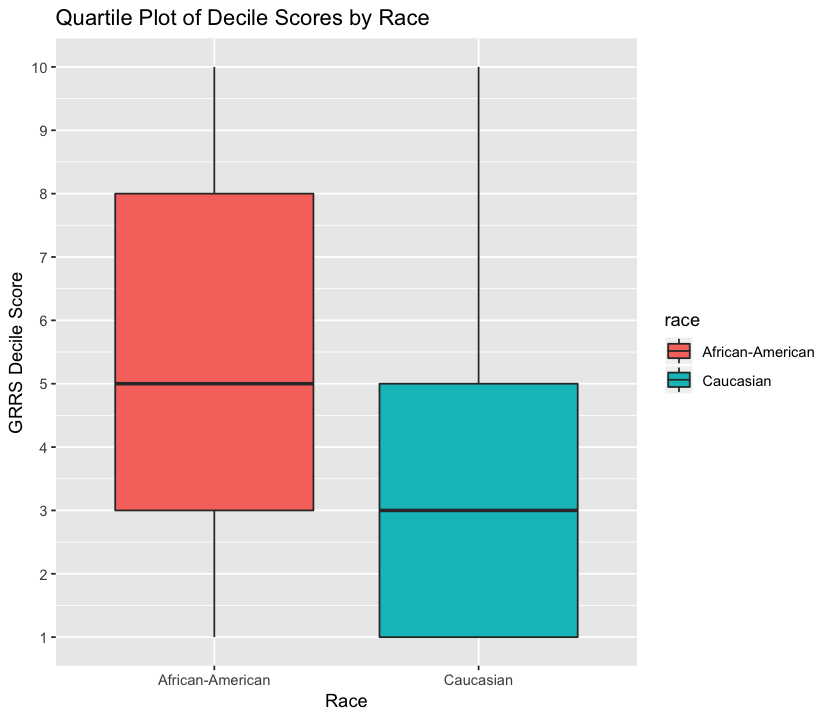

In [232]:
race_df <- copy(df) %>%
   filter(race== "African-American" | race == "Caucasian")

options(repr.plot.width = 7, repr.plot.height = 6)

race_df %>%
    ggplot(aes(ordered(decile_score), fill = race)) + 
        geom_bar() + 
        xlab("Decile Score")  + 
        ylab("Count") +
        ggtitle("Histogram of GRRS for Pre Trial Defendents by Race") +
        facet_wrap(~race, ncol = 1)

race_df %>%
    ggplot(aes(race, as.numeric(decile_score), fill = race)) + 
        geom_boxplot() + 
        scale_y_continuous(breaks = 1:10) +
        xlab("Race")  + 
        ylab("GRRS Decile Score") +
        ggtitle("Quartile Plot of Decile Scores by Race") 

### Plot the proportion defendents in each decile score 

Calculating proportion of defendents who reoffended within two years of release by race is more informative than counting by race.  



In [233]:
# In each decile score what is the proportion of defendents by race 
prop_race <- race_df %>%
    group_by(race, decile_score) %>% 
    summarise(n = n()) %>% 
    group_by(decile_score) %>%
    mutate(prop = n/sum(n))

# In each decile score what is the proportion of defendents by sex
prop_sex <- race_df %>%
    group_by(sex, decile_score) %>% 
    summarise(n = n()) %>% 
    group_by(decile_score) %>%
    mutate(prop = n/sum(n))

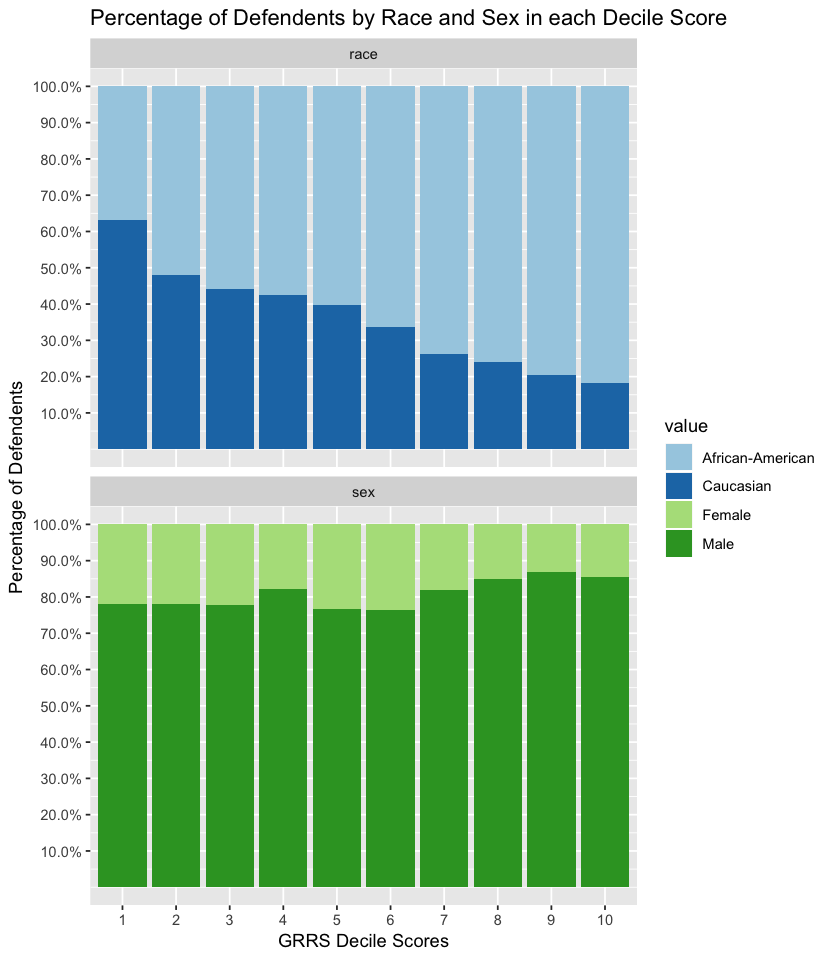

In [239]:
compas_prop <- rbind(prop_race, prop_sex)
compas_prop <- compas_prop %>% 
                    mutate(demograph = ifelse(!is.na(race),"race", "sex"), 
                           value = coalesce(race,sex)) %>%
                    select(-c("race","sex"))

options(repr.plot.width = 7, repr.plot.height = 8)

compas_prop %>%
    ggplot(aes(decile_score, y = prop, group = value, fill = value)) + 
    geom_bar(stat = "identity") +
    ylab("Percentage of Defendents") + 
    xlab("GRRS Decile Scores") + 
    scale_y_continuous(breaks = (1:10)/10, limits = c(0,1), labels = scales::percent)+ 
    scale_fill_brewer(palette = "Paired")+
    ggtitle("Percentage of Defendents by Race and Sex in each Decile Score") +
    facet_wrap(~demograph, ncol = 1) 

## Prevalance (Base Rate)

Among 3696 African-American 2036 had reoffended by year 2014 (55%) and 1901 had reoffended within two years of release (51%).

Among 2454 Caucasian 1025 had reoffended by year 2014 (42%) and 966 had reoffended within two years of release (31%).  


In [214]:
count(race_df, race, is_recid)
count(race_df, race, two_year_recid)

race,is_recid,n
African-American,0,1660
African-American,1,2036
Caucasian,0,1429
Caucasian,1,1025


race,two_year_recid,n
African-American,0,1795
African-American,1,1901
Caucasian,0,1488
Caucasian,1,966


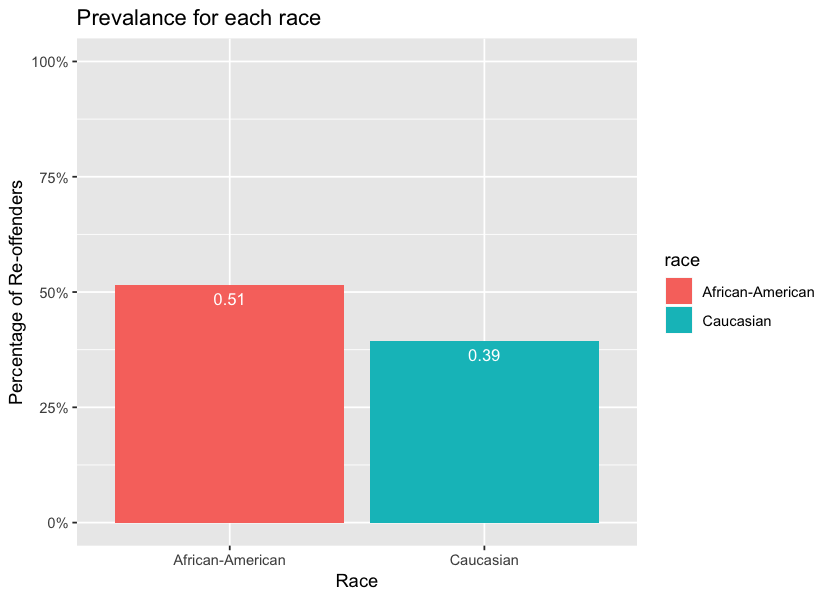

In [307]:
base_df <- race_df %>% 
  group_by(race, two_year_recid) %>% 
  summarize(n = n())

base_df2 <- base_df  %>%
  group_by(race) %>%
  mutate(total = sum(n), prop = round(n/total, 4))

prev <- base_df2 %>%
  filter(two_year_recid == "1" )

options(repr.plot.width = 7, repr.plot.height = 5)

prev %>%
    ggplot(aes(race, prop, fill = race)) + 
    geom_bar(stat = "identity", position = "dodge")  + 
    scale_y_continuous( limits = c(0,1), labels = scales::percent) +
    geom_text(aes(label= round(prop, 2)), vjust= 1.6, color= "white", size=3.5) + 
    ylab("Percentage of Re-offenders") + 
    xlab("Race") +
    ggtitle("Prevalance for each race") 

# Calibration

For every decile score, calculate the proportion of defendents who reoffended within two years of release by race

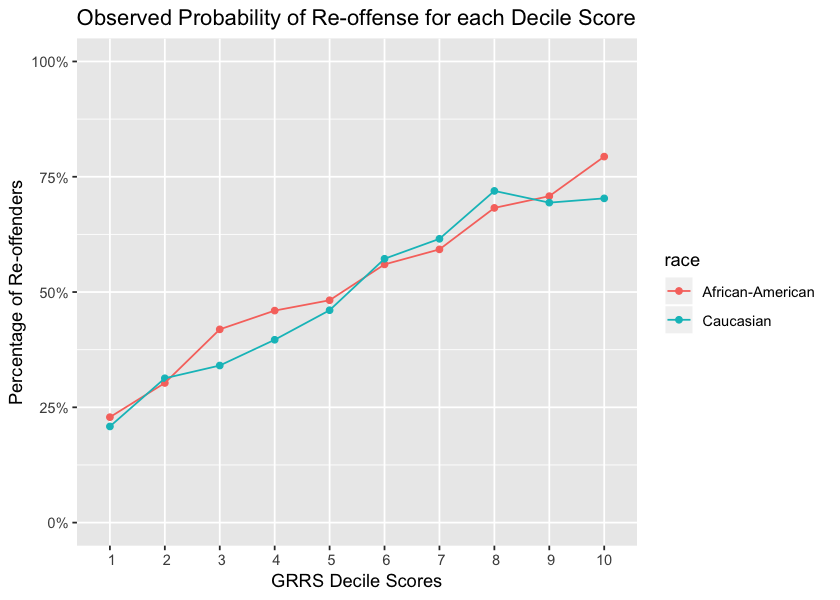

In [308]:
base_decile <- race_df %>% 
  group_by(race, two_year_recid, decile_score) %>% 
  summarise(n = n())

base_decile2 <- base_decile %>% 
  group_by(race, decile_score) %>% 
  mutate(total = sum(n), prop = n/total)

cali <- base_decile2 %>% 
  filter(two_year_recid == 1) 

ggplot(cali, aes(decile_score, prop, col = race, group = race)) + 
  geom_point() +
  geom_line() + 
  scale_x_discrete(limits = c(1:10)) +
  scale_y_continuous( limits = c(0,1), labels = scales::percent) +
  ylab("Percentage of Re-offenders") + 
  xlab("GRRS Decile Scores")  + 
  ggtitle("Observed Probability of Re-offense for each Decile Score")



# Threshold

Since the outcome is binary (either recidivist or not recidivist), we need to group the decile scores into two categories so that it can be tested for accuracy and bias. 

There are two types of error that prediction can make: false positive and false negative. In this case, false positive means a person classified as high-risk did not recidivate, while false negative means a person classified as low-risk person did re-offend. If we are willing to set more non-innocents free then we must avoid high false positives, and if we willing to lock up innocent people then we must avoid high false negatives. Deciding the threshold depends on what the policy makers are aiming to achieve.  


### What is the best tool available to check for bias in a prediction model? 


### How does accuracy and bias in prediction change when different threshold for decile scores are selected? 

In predictive analytics, a two-by-two contingency table (sometimes also called a confusion matrix), is a table that reports the number of false positives, false negatives, true positives, and true negatives. This allows more detailed analysis than mere proportion of correct classifications as a whole (accuracy). 

<i></i>| predicted high-risk of reoffense when score above a threshold|predicted low-risk of reoffense when score below a threshold
-|-|-
actual reoffender|True Positive (TP)|False Negative (FN)
actual non-reoffender|False Positive (FP)|True Negative (TN)

    TP: defendents who reoffended classified as high-risk of reoffense
    FN: defendents who reoffended classified as low-risk of reoffense
    TN: defendents who did not reoffended classified as low-risk of reoffense
    FP: defendents who did not reoffended classified as high-risk of reoffense

Confusion matrix could be used to calculate accuracy and identify bias in predictions with binary outcomes. Therefore we need to select a threshold. For an example, when threshold is 4, decile score at or below 4 are classified as low-risk and score above 4 are classified as high-risk of reoffense. 

**Accuracy** means the proportion of correctly predicting reoffense overall. 
$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN} 
$$ 

**Precision** means the proportion of correctly predicting people as high-risk among those who were predicted as high-risk by the model. 

$$
Precision = \frac{TP}{TP + FP}
$$ 

**Sensitivity** or **True Positive Rate** means the proportion of correctly predicting people as high-risk of reoffense among those who reoffended. 

$$
Sensitivity = \frac{TP}{TP + FN} 
$$ 

**False Positive Rate (FPR)** means the proportion of wrongly predicting people as high-risk of reoffense among those who did-not reoffended. 

$$
FPR = \frac{FP}{TN + FP}
$$

**False Negative Rate (FNR)** means the proportion of wrongly predicting people as low-risk of reoffense among those who reoffended. 
$$
FNR = \frac{FN}{TP + FN}
$$

**False Discovery Rate (FDR)** means the proportion of wrongly predicting people as high-risk of reoffense among those predicted as high-risk of reoffense by the model. 
$$
FDR = \frac{FP}{TP + FP}
$$

**False Omnision Rate (FOR)** means the proportion of wrongly predicting people as high-risk of reoffense among those predicted as low-risk of reoffense by the model. 

$$
FOR = \frac{FN}{TN + FN}
$$


**Area Under Curve Receiver Operating Characteristic (AUC-ROC)** is the area under the curve when 1 - Specificity is plotted on X-axis and Sensitivity is plotted on Y-axis. The plot shows the trade-off between Sensitivity and Specificity. AUC-ROC of 80 and above is considered to be good. 

We want to observe how the confusion matrix changes as threshold changes. So, we will set decile score 1 as predicted "low-risk" and 2-10 as predicted "high-risk". Then, we will compute confusion matrix for that predictions and repeat the process for every other thresholds to check if some types of categorization are better than other.

Categorize data into threshold 0-10. Then calculate the number of True Postive, True Negative, False Positive and False Negative, and use the results to find the accuracy, and other statistical tests.


In [309]:
make_matrix <- function( decile ) {
    compas_DT <- copy(race_df)
    compas_DT$decile_score <- as.numeric(compas_DT$decile_score)
    compas_DT <- compas_DT %>%
                    mutate(decile_cat = ifelse(decile_score <= decile, "low", "high"))
 
df1 <- compas_DT %>%
  filter(decile_cat == "high", two_year_recid == 1) %>%
  group_by(race) %>%
  summarize(true_positive = n())

df2 <- compas_DT %>%
  filter(decile_cat == "low", two_year_recid == 1) %>%
  group_by(race) %>%
  summarize(false_negative = n())

df3 <- compas_DT %>%
  filter(decile_cat == "high", two_year_recid == 0) %>%
  group_by(race) %>%
  summarize(false_positive = n())

df4 <- compas_DT %>%
  filter(decile_cat == "low", two_year_recid == 0) %>%
  group_by(race) %>%
  summarize(true_negative = n())

return( df1 %>%
  full_join(df2, by = c("race", "race")) %>%
  full_join(df3, by = c("race", "race")) %>%
  full_join(df4, by = c("race", "race")) %>%
  mutate(threshold = as.character( decile ) ) )
}
 
full_matrix <- bind_rows(make_matrix( 0 ), make_matrix( 1 ), make_matrix( 2 ), make_matrix( 3 ), make_matrix( 4 ), make_matrix( 5 ), make_matrix( 6 ), make_matrix( 7 ), make_matrix( 8 ), make_matrix( 9 ), make_matrix( 10 )) 

full_matrix[is.na(full_matrix)] <- 0

full_matrix2 <- full_matrix %>%
  group_by(race, threshold) %>%
  mutate(total = sum(true_positive, true_negative, false_positive, false_negative)) %>%
  mutate(accuracy = (true_positive + true_negative)/total,
         overall_misclass_rate =  1- accuracy, 
         prevalance = (true_positive + false_negative)/total,
         predicted_probability = (true_positive + false_positive)/total,
         true_positive_rate = true_positive/(true_positive + false_negative),
         true_negative_rate = true_negative/(true_negative + false_positive), 
         false_positive_rate = false_positive/(false_positive + true_negative), 
         false_negative_rate = false_negative/(false_negative + true_positive),
         positive_predicted_value = true_positive/(true_positive + false_positive),
         negative_predicted_value = true_negative/(true_negative + false_negative),
         false_discovery_rate = false_positive/(false_positive + true_positive), 
         false_omission_rate = false_negative/(false_negative + true_negative)) 

# Angwin et al. used threshold of 4. 

full_matrix2 %>% 
  filter(threshold == "4") 

race,true_positive,false_negative,false_positive,true_negative,threshold,total,accuracy,overall_misclass_rate,prevalance,predicted_probability,true_positive_rate,true_negative_rate,false_positive_rate,false_negative_rate,positive_predicted_value,negative_predicted_value,false_discovery_rate,false_omission_rate
African-American,1369,532,805,990,4,3696,0.6382576,0.3617424,0.5143398,0.5882035,0.7201473,0.551532,0.448468,0.2798527,0.6297148,0.6504599,0.3702852,0.3495401
Caucasian,505,461,349,1139,4,2454,0.6699267,0.3300733,0.3936430,0.3480033,0.5227743,0.765457,0.234543,0.4772257,0.5913349,0.7118750,0.4086651,0.2881250


In [310]:
# To add error bars in plots compute standard error for useful columns
se <- function(n, p) {
    round(1.96 * sqrt((p*(1-p))/n), 4)
}

lst_vars <-  names(full_matrix2[, 8:ncol(full_matrix2)])
lst_vars

final_matrix <- copy(full_matrix2) %>%
        mutate_at(lst_vars, funs(se = se(total,.)))



[1] "accuracy"                 "overall_misclass_rate"   
 [3] "prevalance"               "predicted_probability"   
 [5] "true_positive_rate"       "true_negative_rate"      
 [7] "false_positive_rate"      "false_negative_rate"     
 [9] "positive_predicted_value" "negative_predicted_value"
[11] "false_discovery_rate"     "false_omission_rate"

In [311]:
# Arrange threshold 
final_matrix$threshold <- factor(final_matrix$threshold, c("0","1", "2","3","4","5","6", "7", "8", "9", "10"))


As you can see above among African-American non-reoffenders 45 % were misclassfied as being high-risk and among African-American reoffenders 28% were misclassfied as being low-risk. Whereas among Caucasian non-reoffenders 23% were misclassfied as being high-risk and among Caucasian reoffenders 48% were misclassfied as being low-risk. 

On the other hand, among African-American who were classified as low-risk of reoffense 35% were misclassfied as being low-risk and among African-American who were classified as high-risk of reoffense 37% were misclassfied as being low-risk. Whereas among Caucasian who were classified as low-risk of reoffense 29% were misclassfied as being high-risk and who were classified as high-risk of reoffense 41% were misclassfied as being low-risk.

### Plot the accuracy for each threshold by race. 

The x-axis represents thresholds and the y-axis represents the acurracy in percentage. The graph tells us that the accuracy for African-American is better than Caucasian up to threshold 3, whereas from threshold 4 onwards accuracy for Caucasian increases and we can see substantiate difference in accuracy at threshold 9. 

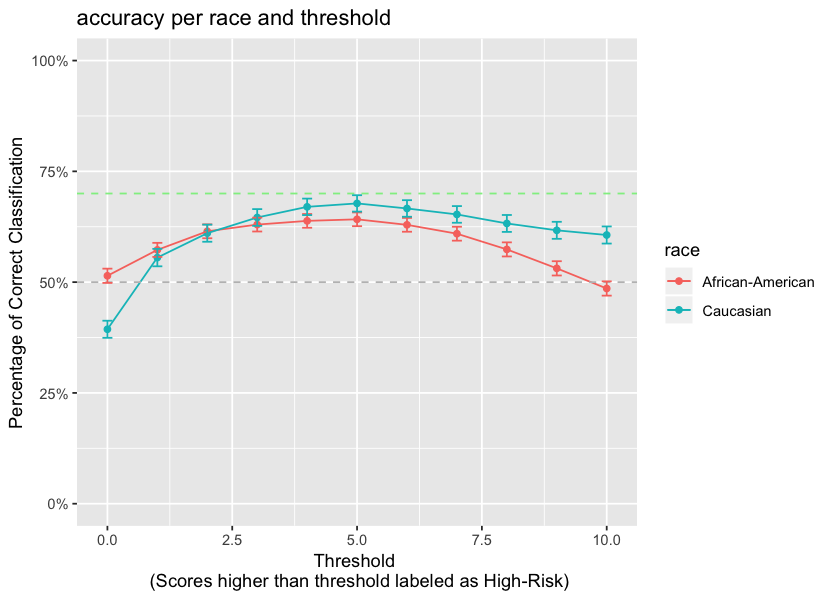

In [313]:
plot_data <- function(data, y_var, y_label){ 
    x_var <- "threshold"
    z_var <- "race"
    data$threshold <- as.numeric(as.character(data$threshold))
    if(y_var == "accuracy"){
        data %>%
            ggplot(aes_string(x = x_var,  y = y_var, color = z_var, group = z_var)) + 
            geom_point() +
            geom_line() +
            geom_hline(yintercept=.7, linetype=2, color = "lightgreen")  +
            geom_hline(yintercept=.5, linetype=2, color = "gray")  +
            geom_errorbar(aes_string(ymin = paste0(y_var, " - ", paste0(y_var, "_se")), 
                                     ymax = paste0(y_var, " + ", paste0(y_var, "_se"))), width = 0.2) +
            scale_y_continuous(limits = c(0,1), labels = scales::percent) + 
            labs(title = paste0(y_var, " per ", z_var, " and ", x_var),
                 x = "Threshold \n (Scores higher than threshold labeled as High-Risk)", 
                 y =  paste(y_label))
    } else {
        data %>%
            ggplot(aes_string(x = x_var,  y = y_var, color = z_var, group = z_var)) + 
            geom_point() +
            geom_line() +
            geom_errorbar(aes_string(ymin = paste0(y_var, " - ", paste0(y_var, "_se")), 
                                     ymax = paste0(y_var, " + ", paste0(y_var, "_se"))), width = 0.2) +
            scale_y_continuous( limits = c(0,1), labels = scales::percent) + 
            labs(title = paste0(str_replace_all(y_var, "_", " "), " per ", z_var, " and ", x_var),
                 x = "Threshold \n (Scores higher than threshold labeled as High-Risk)", 
                 y =  paste(y_label))
    }
}

plot_data(final_matrix, y_var = "accuracy", y_label = "Percentage of Correct Classification")

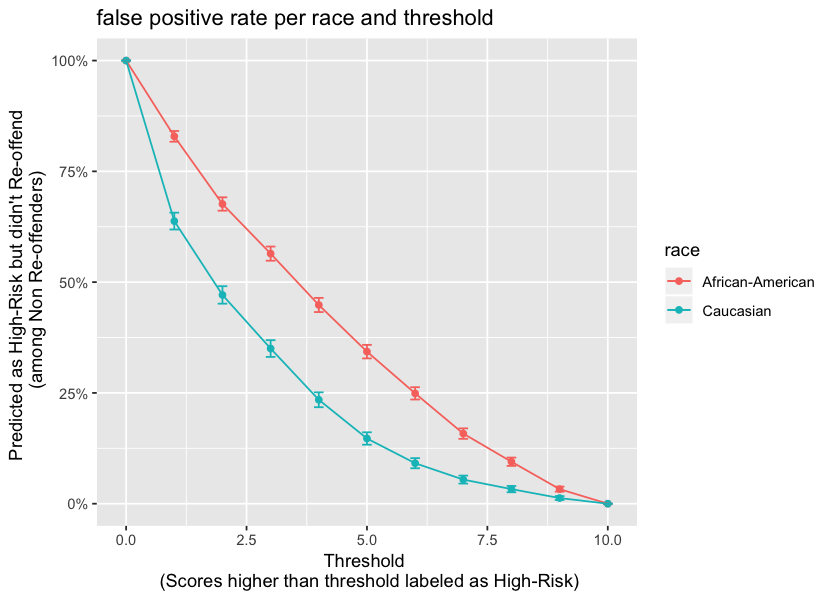

Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

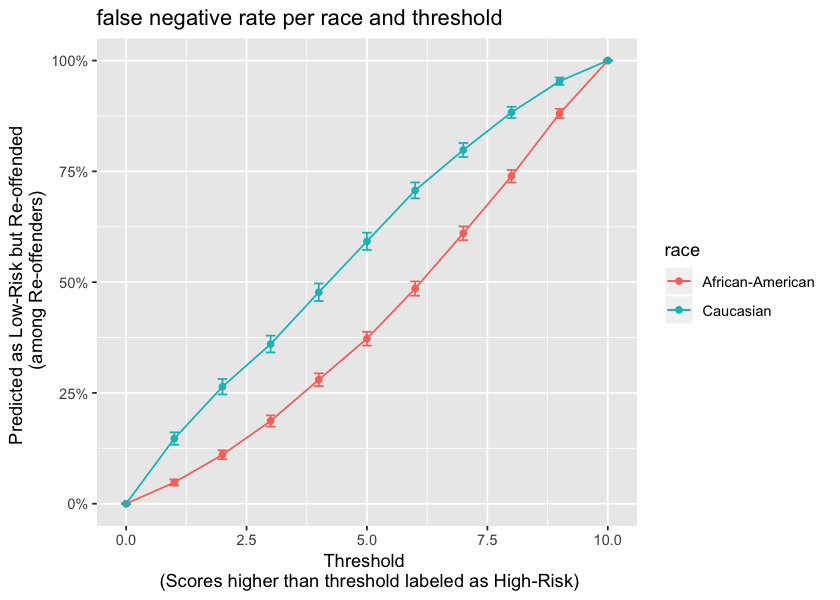

Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

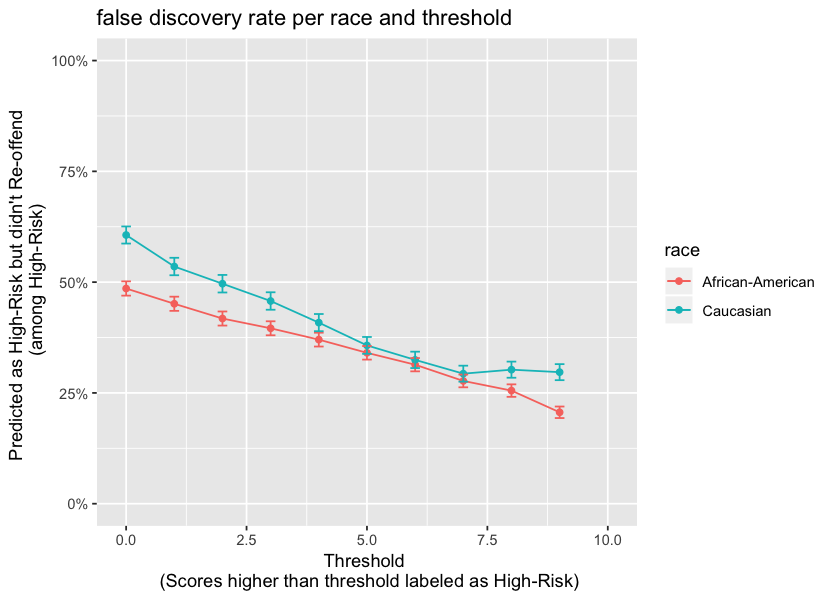

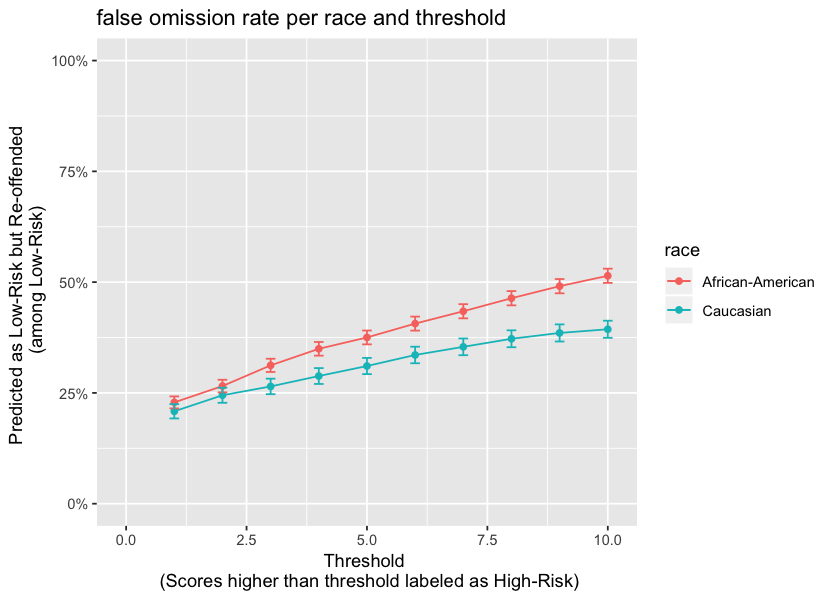

In [314]:
plot_data(final_matrix, y_var = "false_positive_rate", 
          y_label = "Predicted as High-Risk but didn't Re-offend \n (among Non Re-offenders)")

plot_data(final_matrix, y_var = "false_negative_rate", 
          y_label = "Predicted as Low-Risk but Re-offended \n (among Re-offenders)")

plot_data(final_matrix, y_var = "false_discovery_rate", 
          y_label = "Predicted as High-Risk but didn't Re-offend \n (among High-Risk)")

plot_data(final_matrix, y_var = "false_omission_rate", 
          y_label ="Predicted as Low-Risk but Re-offended \n (among Low-Risk)")
 

The two graphs-- False Positive Rate and False Negative Rate--show that African-American has higher false positive rate and lower false negative rate across each threshold, this shows that African-American suffers from disparate mistreatment. In "Fairness Beyond Disparate Treatment & Disparate Impact: Learning Classification without Disparate Mistreatment " Zafar, et al. proposes disparate mistreatment as well-suited for scenarios where ground truth is available for historical decisions used during the training phase [3]. They write that a decision making process suffers from disparate mistreatment with respect to a given sensitive attribute (e.g., race) if the misclassiffcation rates differ for groups of people having different values of that sensitive attribute. 

The accuracy plot shows that threshold of 5 for African-American and threshold of 3 for caucasian perform with similar accuracy. If we want to minimize the false positive rates then selecting higher threshold is appropriate, however it comes with the cost of lesser true positives rates, which impacts the accuracy. 

While ROC is plotted with True Positive Rate as a function of False Positive Rate, it displays the trade-off True Positive Rate (sensitivity) and True Negative Rate(specificity). 


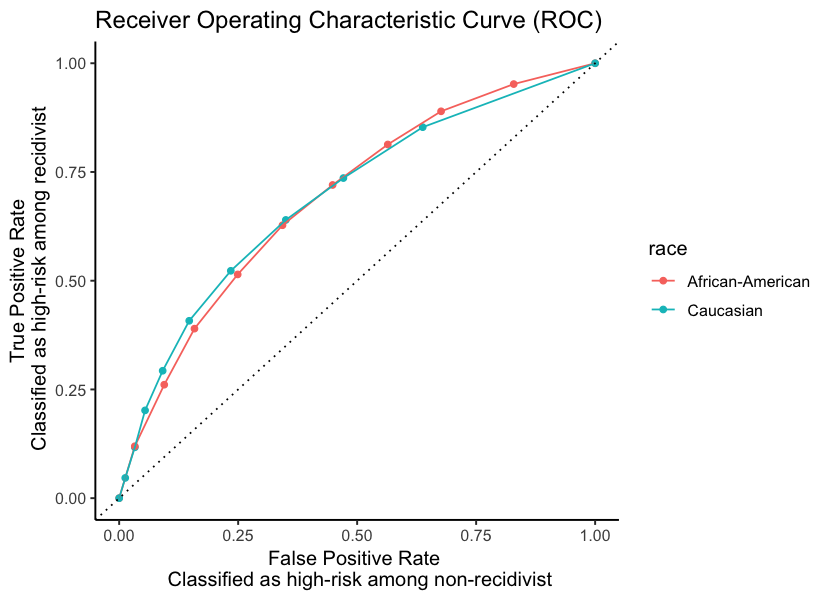

In [315]:
full_matrix2 %>%
    ggplot(aes(false_positive_rate, true_positive_rate, col = race, label = threshold, group = race)) +  
    geom_point() +
    geom_line()  +
    theme_classic(base_size = 12) +
    xlab("False Positive Rate \n Classified as high-risk among non-recidivist") + 
    ylab("True Positive Rate\n Classified as high-risk among recidivist") + 
    geom_abline(intercept=0, slope=1, lty=3) + 
    xlim(0,1) + 
    ylim(0,1) +
    ggtitle("Receiver Operating Characteristic Curve (ROC)") 





#### References 

[1] Angwin, Julia. “Machine Bias: There’s Software Used across the Country to Predict Future 
Criminals. And It’s Biased against Blacks.” ProPublica, 23 May 2016, 
www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing.

[2] Dieterich, William, et al. “COMPAS Risk Scales: Demonstrating Accuracy Equity and 
Predictive Parity.” Equivant, NorthPointe, 8 July 2016,
go.volarisgroup.com/rs/430-MBX-989images/ProPublica_Commentary_Final_070616.pdf.

[3] Zafar, Muhammad Bilal, et al. “Learning Classification without Disparate Mistreatment.” Fairness Beyond Disparate Treatment & Disparate Impact, International World Wide Web Conferences Steering Committee, 8 Mar. 2017, doi.acm.org/10.1145/3038912.3052660.

